## Notebook for exploring the MAE of the visual features
#### Outline
-  Prepare data
    - Load model from checkpoint
    - Get image representations from iNaturalist dataset validation set
- Exploring latent space of MAE model

In [16]:

import datetime
import json
import numpy as np
import pandas as pd
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from util.pos_embed import interpolate_pos_embed
import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)
path_meta = Path('meta').mkdir(exist_ok=True, parents=True)

1.21.6
1.4.2
1.8.2+cpu


# Get Embedding
- from iNaturelist 2021 validation dataset
    - size: 15k
- encoder 
    - MAE encoder
    - ViT from Fine-tune of MAE encoder 

### Load encoder

In [2]:
encoder_version='LP'
global_pool = False
ck_ft = 'ebird_FT_cls_vit_base_checkpoint-99.pth'
ck_lp = 'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'
 
def load_encoder(nb_classes:int=1486, global_pool:bool=False, encoder_version:str='FT', **kwargs):
    assert encoder_version.upper() == 'FT' or encoder_version.upper() =='LP', f'Encoder_version must be either FT or LP, got {encoder_version}'
    print(f'Encoder  : {encoder_version.upper()}')
    if encoder_version.upper()=='LP':
        ck = ck_lp  
    elif encoder_version.upper()=='FT':
        ck = ck_ft
        
    model = models_vit.__dict__['vit_base_patch16'](
        num_classes=nb_classes, global_pool=global_pool, )
    checkpoint = torch.load(ck, map_location='cpu')
    

    print(f"Load pre-trained checkpoint from: {ck}")
    checkpoint_model = checkpoint['model']

    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

encoder = load_encoder(encoder_version=encoder_version)

Encoder  : LP
Load pre-trained checkpoint from: ebird_LP_cls_2fc_vit_base_checkpoint-89.pth
_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['head.0.running_mean', 'head.0.running_var', 'head.0.num_batches_tracked', 'head.1.weight', 'head.3.weight'])


### Prepare dataset

In [ ]:
# simple augmentation
transform_toTensor = transforms.Compose([
                    transforms.Resize(256, interpolation=3),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()
                        ])
#dataset_train = datasets.ImageFolder(os.path.join(args.data_path), transform=transform_train)
data_path = '../../share/iNaturalist_2021'
dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=transform_toTensor)
print(dataset)

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False,
        num_workers=8,  batch_size=500,)

### get embedding

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)

start_time = time.time()
for i, (images, *_) in enumerate(data_loader):
    images = images.to(device)
    
    with torch.no_grad():
        embedding_ = encoder.forward_features(images)
        # embedding_ = embedding_.detach().cpu().numpy()

    if i == 0 :
        embeddings = embedding_
    else:
        embeddings = torch.cat((embeddings, embedding_), axis=0)    
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Progress:{i+1:4d}, {100*(i+1)/len(data_loader):3.2f}%. ' 
    info += f'| Feature_shape: {embeddings.shape}.' 
    info += f'| Time: {passing_time}. '
    print(info, end='\r')

#     if i==3:
#         break


In [50]:
encoder_version ='LP'
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

file_ = f'embeddings_iNatureVal_{encoder_version}.npz'
# np.savez_compressed(path_embeddings/file_, embedding=embeddings.cpu().numpy() )
# np.save(path_embeddings.joinpath(file_) , embeddings)
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)

df_embedding = pd.DataFrame(embeddings)
df_embedding

(14872, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.007730,-0.045795,0.311841,-0.041940,0.181851,-0.018674,-0.040257,0.059418,0.003868,0.056336,...,0.014388,0.254245,0.069015,0.131525,-0.060207,-0.008528,-0.168544,-0.014763,-0.137933,0.075730
1,-0.015181,-0.031574,0.267418,0.011679,0.149790,0.128244,-0.131941,0.121562,-0.068382,-0.035608,...,0.096321,0.235173,0.166284,0.154657,-0.119892,0.030714,-0.044580,-0.089171,-0.128675,0.042460
2,-0.049553,-0.020102,0.289890,0.021244,0.176667,0.117614,-0.093537,0.108440,0.031226,-0.010255,...,0.001410,0.263002,0.130754,0.105091,-0.135176,0.022855,0.048064,-0.102540,-0.136005,0.098132
3,-0.116881,0.042870,0.229970,-0.014931,0.185965,0.118523,-0.104391,0.089745,0.048706,0.060649,...,-0.035995,0.216594,0.072737,0.155766,-0.082776,-0.026272,-0.129001,-0.085289,-0.123667,0.126398
4,-0.045988,0.021619,0.299169,0.057567,0.137458,0.193083,-0.077236,0.149005,0.063512,0.144669,...,0.021763,0.237027,0.083393,-0.163963,-0.118053,0.038206,-0.103086,-0.030006,-0.050578,0.128207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867,0.020397,-0.055544,0.284097,0.007256,0.137608,0.028326,-0.054992,0.097724,-0.032008,0.055138,...,0.141799,0.294315,0.118659,0.072749,-0.129784,0.025368,-0.152060,-0.122494,-0.119267,0.110769
14868,-0.018260,-0.022672,0.286666,0.008911,0.178441,0.029565,-0.103524,0.061511,0.054928,-0.041342,...,0.048636,0.255195,0.109560,0.044152,-0.116156,-0.039896,-0.063332,-0.120237,-0.119608,0.114087
14869,-0.010282,-0.031364,0.284866,0.084723,0.096948,0.027496,-0.063392,0.062636,0.090986,0.002865,...,0.124581,0.245764,0.141846,0.103433,-0.141114,0.053003,-0.161006,-0.067689,-0.048885,0.104620
14870,-0.057658,0.007338,0.325469,0.062210,0.098198,0.042627,-0.073996,0.173677,0.054926,0.062979,...,0.054029,0.112070,0.074295,0.100463,-0.066478,-0.001193,-0.131217,-0.115611,-0.073539,0.049849


In [51]:
df_dim_stat = pd.DataFrame(columns=['mean', 'std', 'min', 'max'])
df_dim_stat  = (pd.concat([df_embedding.mean(), df_embedding.std(), df_embedding.min(), df_embedding.max()], axis=1)
            .set_axis(['mean', 'std', 'min', 'max'], axis=1)
            )
df_dim_stat


,mean,std,min,max
0,-0.053076,0.055696,-0.245851,0.120042
1,-0.000792,0.038994,-0.148658,0.150059
2,0.283038,0.065044,-0.009744,0.579673
3,0.009813,0.050518,-0.166640,0.220656
4,0.145108,0.040974,-0.008273,0.327588
...,...,...,...,...
763,0.064451,0.070918,-0.225227,0.346127
764,-0.118985,0.080119,-0.427920,0.214844
765,-0.104623,0.073507,-0.364614,0.206603
766,-0.092167,0.057390,-0.328861,0.152325


In [52]:

token = 'cls' if global_pool==False else 'gap'
title = f'Embedding Distribution_{encoder_version.upper()}_{token}'


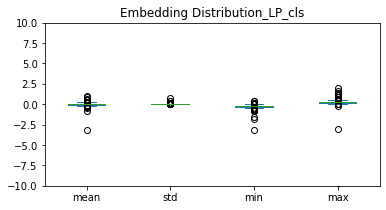

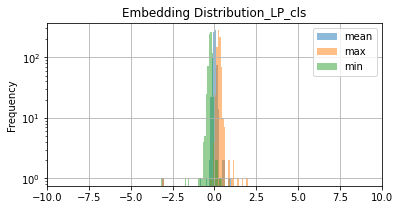

In [53]:
figsize=(6,3)
df_dim_stat.plot(kind='box',figsize=figsize, title=title, ylim=(-10,10));
(df_dim_stat[['mean',
              'max','min'
              ]]
 .plot(grid=True, figsize=figsize, title=title,
     kind='hist', bins=200, logy=True, alpha=0.5,
       xlim=(-10,10),                     
                                       ));

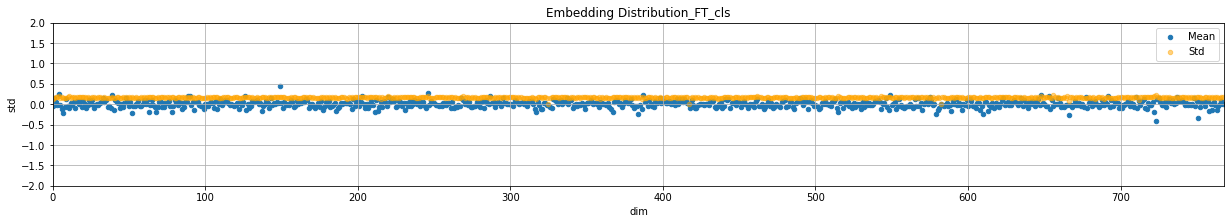

In [33]:
figsize=(21,3)
ax = (df_dim_stat.reset_index().rename(columns={'index':'dim'})
 .plot.scatter(x='dim', y='mean', label='Mean',  
     figsize=figsize, title=title, ylim=(-2,2), xlim=(0,768), grid=True)
 )
figsize=(21,3)
(df_dim_stat.reset_index().rename(columns={'index':'dim'})
 .plot.scatter(x='dim', y='std', label='Std',
     figsize=figsize, title=title, xlim=(0,768), grid=True, c='orange', alpha=0.5,ax=ax)
 );



In [54]:
print(f'{encoder_version.upper()}_{token}')
df_dim_stat.query('mean > 0.5 or mean <-0.5')

LP_cls


,mean,std,min,max
149,0.632264,0.412052,-0.887781,1.976016
317,0.993252,0.186559,0.455218,1.660658
325,-13.293757,0.796640,-15.843514,-10.385648
406,0.628176,0.124746,0.132028,1.081106
417,-3.102415,0.009912,-3.146698,-3.067003
582,0.531573,0.126155,0.015036,1.125060
653,0.504704,0.077594,0.192608,0.846880
666,0.859316,0.134210,0.371548,1.396645
723,-0.812560,0.199957,-1.512450,0.141445


/home/yunghui_wsl/yes/envs/python39/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:568: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


<AxesSubplot:title={'center':'Embedding Distribution_FT_cls'}, ylabel='Frequency'>

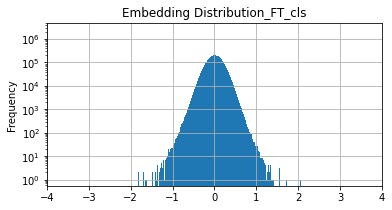

In [49]:
figsize = (6,3)
xlim=(-4,4)
ylim=(0,5e6)
(df_embedding.stack().plot
 .hist(bins=500, figsize=figsize, title=title, grid=True, xlim=xlim, ylim=ylim, logy=True)
)

<AxesSubplot:title={'center':'Embedding Distribution_FT_cls'}, ylabel='Frequency'>

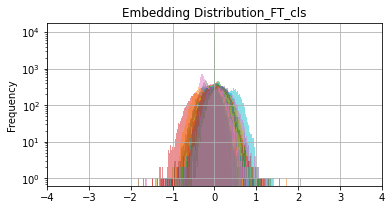

In [36]:
figsize = (6,3)
df_embedding.plot.hist(bins=500, figsize=figsize, title=title, grid=True, legend=False,  logy=True, alpha=0.5
                    ylim=ylim,xlim=xlim,)

# Checking model performance in bird classification tasks
- confusion matrix on taxon


In [263]:
encoder_version = 'FT'
load_encoder(encoder_version=encoder_version)

Encoder  : FT
Load pre-trained checkpoint from: ebird_FT_cls_vit_base_checkpoint-99.pth
<All keys matched successfully>


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

# Interpolate latent space, decoding back to image


### run one sample

In [ ]:
file = '../shared/iNaturalist_2021/val/03116_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_trivirgatus/6987197a-6702-497b-b57a-4eb3b9e14ee6.jpg'
img = Image.open(file)
img


In [ ]:
file = '../shared/iNaturalist_2021/val/03637_Animalia_Chordata_Aves_Galliformes_Phasianidae_Phasianus_colchicus/dba9545d-d38a-4c51-ab5e-6ea23cd4340e.jpg'
img2 = Image.open(file)
img2

In [ ]:
# imagenet_mean = np.array([0.485, 0.456, 0.406])
# imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    image = image.detach().cpu()
    image = torch.einsum('nchw->hwc', image)
    assert image.shape[2] == 3
    
    plt.imshow(torch.clip((image) * 255, 0, 255).int())
    # plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def img2tensor(img:Image):
    img_ = img.resize((224, 224))
    img_ = np.array(img_) / 255.
    x = torch.tensor(img_)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x).float()
    return x


#### load MAE model for reconstruction imgs

In [ ]:
# load model for reconstruction imgs
model = models_mae.__dict__['mae_vit_base_patch16'](norm_pix_loss=True)

model_cp = 'ebird_pretrain_1600_vit_base.pth' 
checkpoint = torch.load(model_cp, map_location='cpu')

print(f"Load pre-trained checkpoint from: {model_cp}")
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()

# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)

model.load_state_dict(checkpoint_model)
# model

In [ ]:
[k for k, v in model.named_children()]
# [k for k in model.named_modules()]
# model.modules()


In [ ]:
# Load LP model as MAE Encoder

encoder = 'lp'
ck_ft = 'ebird_FT_cls_vit_base_checkpoint-99.pth'
ck_lp = 'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'
ck = ck_lp if encoder=='lp' else ck_ft
checkpoint = torch.load(ck, map_location='cpu')

print(f"Load pre-trained checkpoint from: {ck_lp}")
checkpoint_model = checkpoint['model']

state_dict = model.state_dict()

# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)

# load pre-trained model
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)

In [ ]:
seed = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

embeddings = []
rec_imgs = []
ids_restores = []
for img_ in [img, img2]:
    x_ = img2tensor(img_).to(device)
    
    # for geting identical ids_restore
    torch.manual_seed(seed)
    
    embedding_, mask_, ids_restore_ = model.forward_encoder(x_, mask_ratio=0)
    ids_restores.append(ids_restore_)
    embedding_ = embedding_.detach().cpu()
    embeddings.append(embedding_)
    pred_ = model.forward_decoder(embedding_, ids_restore_)
    rec_img_ = model.unpatchify(pred_)
    rec_imgs.append(rec_img_)
    
print(ids_restores[0], '\n', ids_restores[1])
assert (ids_restores[0] == ids_restores[1]).all(), "ids_restores not equal"


In [ ]:
save_path = Path('meta')
vutils.save_image(torch.cat(rec_imgs), save_path/'rec_imgs.jpg', nrow=2, padding=2, normalize=False)
vutils.save_image(torch.cat(rec_imgs), save_path/'rec_imgs_norm.jpg', nrow=2, padding=2, normalize=True)

#### reconstruction imgs
- rec_imgs_normalize  
![rec_imgs_normalize](meta/rec_imgs_normalize.jpg)  


- rec_imgs  
![rec_imgs_normalize](meta/rec_imgs.jpg)


In [ ]:
num_inter = 20
num_patch, num_dim = embeddings[0].squeeze(dim=0).shape

interpolate_embedding = []

for idx_d, dim in enumerate(range(num_dim)) :
    emb0_d = embeddings[0].squeeze(dim=0)[:,dim]  # torch.Size([197])
    emb1_d = embeddings[1].squeeze(dim=0)[:,dim]  # torch.Size([197])
    
    interpolate_patch = []
    for idx_p, p in enumerate(range(num_patch)):
        # if p==0 :   # skip pos_embedding
        #     continue
        interpolat_p_ = torch.linspace(emb0_d[p], emb1_d[p], num_inter)
        interpolate_patch.append(interpolat_p_)
        
    interpolate_patch = torch.einsum('pi->ip', torch.stack(interpolate_patch))
    interpolate_embedding.append(interpolate_patch)
    print(f'dim : {dim}, {len(interpolate_patch)}. | patch : {p}, {interpolate_patch.shape}', end='\r')
    

# (768, 24, 197) embedding, interpolate_patch, patches > (24, 197, 768)
interpolate_embedding = torch.einsum('eip->ipe', torch.stack(interpolate_embedding)) 
print('\n',interpolate_embedding.shape)
    

In [ ]:
# reconstruct interpolated images

assert (ids_restores[0] == ids_restores[1]).all(), "ids_restores not equal"
ids_restore_ = ids_restores[0]

rec_interpolated_imgs = [] 

for i_ipl, embedding_ in enumerate(interpolate_embedding):
    print(i_ipl, embedding_.shape, end='\r')

    pred_ = model.forward_decoder(embedding_.unsqueeze(dim=0), ids_restore_)
    rec_img_ = model.unpatchify(pred_)
    rec_interpolated_imgs.append(rec_img_)

rec_interpolated_imgs = torch.stack(rec_interpolated_imgs).squeeze(dim=1)
print(rec_interpolated_imgs.shape)


In [ ]:
save_path = Path('meta')
nrow=int(num_inter/4)
vutils.save_image(rec_interpolated_imgs , save_path/'interpolate_rec_imgs.jpg', nrow=nrow, padding=1, normalize=False)
vutils.save_image(rec_interpolated_imgs , save_path/'interpolate_rec_imgs_norm.jpg', nrow=nrow, padding=1, normalize=True)

---

# Exploring Embeddings

In [ ]:
# Exploring Position Embedding
pd.DataFrame(model.pos_embed.mean(dim=1)).T.plot(title='mean_dim', figsize=(9,3));
pd.DataFrame(model.pos_embed.std(dim=1)).T.plot(title='std_dim', figsize=(9,3));

In [ ]:
pd.DataFrame(model.pos_embed.mean(dim=2)).T[1:].plot(title='mean_patch', figsize=(9,3));
pd.DataFrame(model.pos_embed.std(dim=2)).T[1:].plot(title='std_patch', figsize=(9,3));